In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from transition_matrix import get_transition_matrix, get_uniform_matrix
from scc_dags import get_scc_dag, get_ordered_states, get_attractor_states
from matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff, get_dkl, get_confusion_matrix
from grouping import sd_grouping, null_grouping, random_grouping
from reachability import get_convergence_matrix


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["rmsd"] = {}
    data["dkl"] = {}
    data["basins"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    stg = primes2stg(percolated_primes, update)
    scc_dag = get_scc_dag(stg)
    scc_indices = get_ordered_states(scc_dag, as_indices=True, DEBUG=DEBUG)
    attractor_indices = get_attractor_states(scc_dag, as_indices=True, DEBUG=DEBUG)
    percolated_bnet = primes2bnet(percolated_primes)

    # Get convergence probability matrix for the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)
    T_convergence_matrix, transient_states, _ = get_convergence_matrix(T_inf, scc_indices, attractor_indices, DEBUG=DEBUG)

    if len(transient_states) == 0:
        return data

    # Get convergence probability matrix for the sd grouped transition matrix
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tsd_inf = nsquare(Tsd, 20, DEBUG=DEBUG)
    Tsd_inf_expanded = expand_matrix(Tsd_inf, sd_indices, DEBUG=DEBUG)
    Tsd_convergence_matrix, _, _ = get_convergence_matrix(Tsd_inf_expanded, scc_indices, attractor_indices, DEBUG=DEBUG)

    # Get convergence probability matrix for the null grouped transition matrix
    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)
    Tnull_inf = nsquare(Tnull, 20, DEBUG=DEBUG)
    Tnull_inf_expanded = expand_matrix(Tnull_inf, null_indices, DEBUG=DEBUG)
    Tnull_convergence_matrix, _, _ = get_convergence_matrix(Tnull_inf_expanded, scc_indices, attractor_indices, DEBUG=DEBUG)

    # Get convergence probability matrix for the uniform matrix
    Tuniform = get_uniform_matrix(2**(len(percolated_primes)))
    Tuniform_convergence_matrix, _, _ = get_convergence_matrix(Tuniform, scc_indices, attractor_indices, DEBUG=DEBUG)

    # Get comparison results
    data["rmsd"]["Tsd"] = get_rms_diff(T_convergence_matrix, Tsd_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["rmsd"]["Tnull"] = get_rms_diff(T_convergence_matrix, Tnull_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["rmsd"]["Tuniform"] = get_rms_diff(T_convergence_matrix, Tuniform_convergence_matrix, partial=True, DEBUG=DEBUG)

    data["dkl"]["Tsd"] = get_dkl(T_convergence_matrix, Tsd_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["dkl"]["Tnull"] = get_dkl(T_convergence_matrix, Tnull_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["dkl"]["Tuniform"] = get_dkl(T_convergence_matrix, Tuniform_convergence_matrix, partial=True, DEBUG=DEBUG)
    
    data["basins"]["Tsd"] = get_confusion_matrix(T_convergence_matrix, Tsd_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["basins"]["Tnull"] = get_confusion_matrix(T_convergence_matrix, Tnull_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["basins"]["Tuniform"] = get_confusion_matrix(T_convergence_matrix, Tuniform_convergence_matrix, partial=True, DEBUG=DEBUG)

    # Get convergence probability matrix for the random matrix and get comparison results
    data["rmsd"]["Trandom"] = []
    data["dkl"]["Trandom"] = []
    data["basins"]["Trandom_TP"] = []
    data["basins"]["Trandom_FP"] = []
    data["basins"]["Trandom_TN"] = []
    data["basins"]["Trandom_FN"] = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        Trandom_inf = nsquare(Trandom, 20, DEBUG=DEBUG)
        Trandom_inf_expanded = expand_matrix(Trandom_inf, random_indices, DEBUG=DEBUG)
        Trandom_convergence_matrix, _, _ = get_convergence_matrix(Trandom_inf_expanded, scc_indices, attractor_indices, DEBUG=DEBUG)

        data["rmsd"]["Trandom"].append(get_rms_diff(T_convergence_matrix, Trandom_convergence_matrix, partial=True, DEBUG=DEBUG))
        data["dkl"]["Trandom"].append(get_dkl(T_convergence_matrix, Trandom_convergence_matrix, partial=True, DEBUG=DEBUG))

        confusion_matrix_random = get_confusion_matrix(T_convergence_matrix, Trandom_convergence_matrix, partial=True, DEBUG=DEBUG)
        data["basins"]["Trandom_TP"].append(confusion_matrix_random[0])
        data["basins"]["Trandom_FP"].append(confusion_matrix_random[1])
        data["basins"]["Trandom_TN"].append(confusion_matrix_random[2])
        data["basins"]["Trandom_FN"].append(confusion_matrix_random[3])
    
    return data

In [3]:
all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["rmsd"]["Tsd"],
          np.mean(all_data[bnet]["rmsd"]["Trandom"]),
          all_data[bnet]["rmsd"]["Tnull"],
          all_data[bnet]["rmsd"]["Tuniform"],

          all_data[bnet]["dkl"]["Tsd"],
          np.mean(all_data[bnet]["dkl"]["Trandom"]),
          all_data[bnet]["dkl"]["Tnull"],
          all_data[bnet]["dkl"]["Tuniform"]
          )

n010_000.bnet 0.11520219179490428 0.44012278133405447 0.440401118011306 0.6445809941770692 144.9094463676842 618.3429252832584 618.8710258459471 3308.282086418534
n010_001.bnet 0.21445478657217348 0.315193497964973 0.3201628733088868 0.36100615784354406 19.92157039279616 66.16767557996496 68.39184516322771 205.68501478286151
n010_002.bnet 0.0 0.0 0.0 0.9921875 0.0 0.0 0.0 616.207843517791
n010_003.bnet 0.0 0.0 0.0 0.9990234375 0.0 0.0 0.0 7090.8956571282415
n010_004.bnet 0.23082610691960995 0.3391035430270761 0.3396964069059909 0.4240081605711862 187.93885718429487 449.5392952265167 451.23259179563973 2927.7116501435685
n010_005.bnet 0.37499999999999983 0.37499999999999994 0.37499999999999983 0.37499999999999983 11.28008710189765 11.280087101897648 11.28008710189765 11.28008710189765
n010_006.bnet 0.2489705840002887 0.31485554558006107 0.31516267539441756 0.5902134386271491 159.00477231333286 253.4996246416878 253.8687876251628 6629.43655441554
n010_007.bnet 0.10126461459900069 0.12037

In [5]:
def plot_rmsd_and_dkl(rmsd, dkl):

    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(rmsd, bins=10, color='blue', alpha=0.7)
    plt.title('RMSD Histogram')
    plt.xlabel('normalized RMSD')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(dkl, bins=10, color='green', alpha=0.7)
    plt.title('Dkl Histogram')
    plt.xlabel('normalized Dkl')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

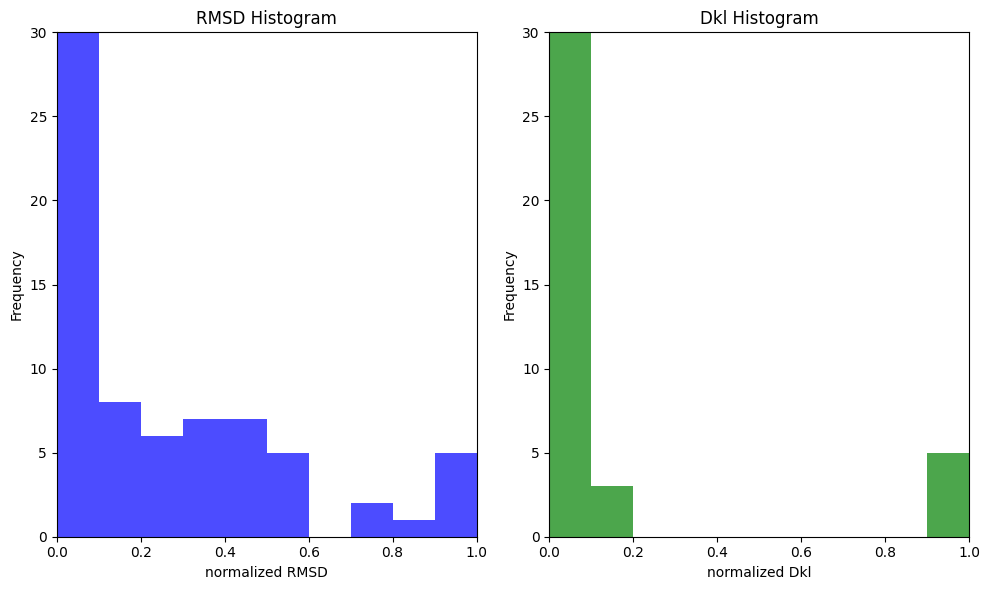

In [6]:
rmsd = []
dkl = []
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        continue
    rmsd.append(all_data[bnet]["rmsd"]["Tsd"] / all_data[bnet]["rmsd"]["Tuniform"])
    dkl.append(all_data[bnet]["dkl"]["Tsd"] / all_data[bnet]["dkl"]["Tuniform"])

plot_rmsd_and_dkl(rmsd, dkl)

In [7]:
for bnet in all_data:
    if len(all_data[bnet]["basins"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["basins"]["Tsd"][0],
          all_data[bnet]["basins"]["Tsd"][1],
          all_data[bnet]["basins"]["Tsd"][2],
          all_data[bnet]["basins"]["Tsd"][3],

          np.mean(all_data[bnet]["basins"]["Trandom_TP"]),
          np.mean(all_data[bnet]["basins"]["Trandom_FP"]),
          np.mean(all_data[bnet]["basins"]["Trandom_TN"]),
          np.mean(all_data[bnet]["basins"]["Trandom_FN"]),

          all_data[bnet]["basins"]["Tnull"][0],
          all_data[bnet]["basins"]["Tnull"][1],
          all_data[bnet]["basins"]["Tnull"][2],
          all_data[bnet]["basins"]["Tnull"][3],

          all_data[bnet]["basins"]["Tuniform"][0],
          all_data[bnet]["basins"]["Tuniform"][1],
          all_data[bnet]["basins"]["Tuniform"][2],
          all_data[bnet]["basins"]["Tuniform"][3],
          )

n010_000.bnet 1352 0 584 0 1352.0 576.0 8.0 0.0 1352 576 8 0 1352 584 0 0
n010_001.bnet 110 26 154 0 110.0 179.96 0.04 0.0 110 180 0 0 110 180 0 0
n010_002.bnet 127 0 0 0 127.0 0.0 0.0 0.0 127 0 0 0 127 0 0 0
n010_003.bnet 1023 0 0 0 1023.0 0.0 0.0 0.0 1023 0 0 0 1023 0 0 0
n010_004.bnet 1290 179 563 0 1290.0 742.0 0.0 0.0 1290 742 0 0 1290 742 0 0
n010_005.bnet 24 0 0 0 24.0 0.0 0.0 0.0 24 0 0 0 24 0 0 0
n010_006.bnet 1914 36 94 0 1914.0 130.0 0.0 0.0 1914 130 0 0 1914 130 0 0
n010_007.bnet 1010 7 3 0 1010.0 10.0 0.0 0.0 1010 10 0 0 1010 10 0 0
n010_008.bnet 406 38 222 0 406.0 260.0 0.0 0.0 406 260 0 0 406 260 0 0
n010_009.bnet 270 2 48 0 270.0 17.0 33.0 0.0 270 17 33 0 270 50 0 0
n010_010.bnet
n010_011.bnet 773 20 638 0 773.0 658.0 0.0 0.0 773 658 0 0 773 658 0 0
n010_012.bnet 1023 0 0 0 1023.0 0.0 0.0 0.0 1023 0 0 0 1023 0 0 0
n010_013.bnet 15 0 24 0 15.0 23.21 0.79 0.0 15 24 0 0 15 24 0 0
n010_014.bnet 4 0 0 0 4.0 0.0 0.0 0.0 4 0 0 0 4 0 0 0
n010_015.bnet 4086 24 1974 0 4086.0 1998

In [8]:
def plot_precision_and_specificity(TP, FP, TN, FN):

    # Lists to store precision and specificity values
    precisions = []
    specificities = []

    # Calculate precision and specificity for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and specificity
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            specificity = tn / (tn + fp)
            specificities.append(specificity)
            
    # Create histograms of precision and specificity
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Specificity
    plt.subplot(1, 2, 2)
    plt.hist(specificities, bins=10, color='green', alpha=0.7)
    plt.title('Specificity Histogram')
    plt.xlabel('Specificity')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


/tmp/ipykernel_23993/3657032108.py:19: RuntimeWarning: invalid value encountered in scalar divide
  specificity = tn / (tn + fp)


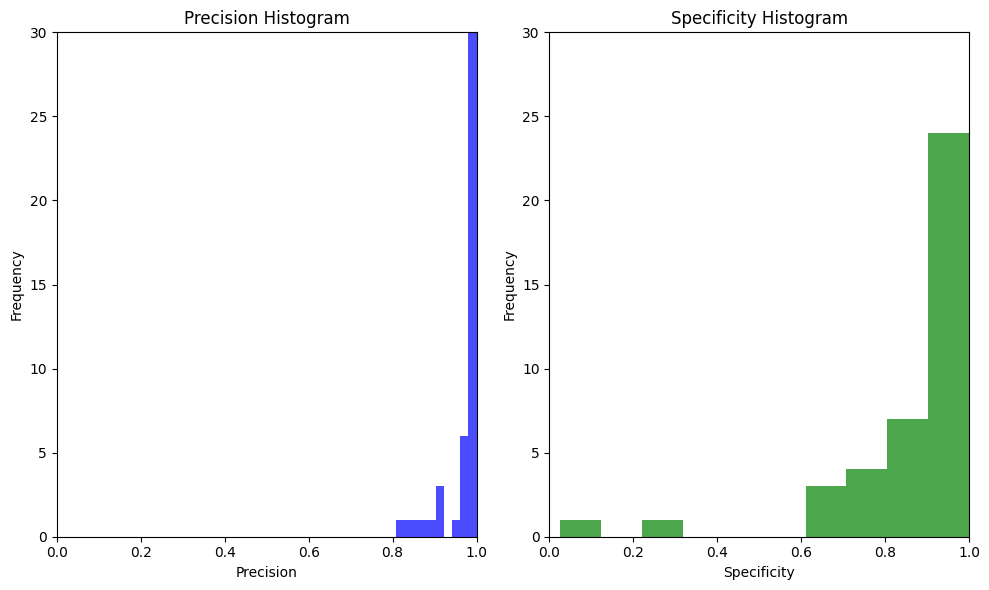

In [9]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["basins"]) == 0:
        continue
    TP.append(all_data[bnet]["basins"]["Tsd"][0])
    FP.append(all_data[bnet]["basins"]["Tsd"][1])
    TN.append(all_data[bnet]["basins"]["Tsd"][2])
    FN.append(all_data[bnet]["basins"]["Tsd"][3])

print(np.arange(0, 1.1, 0.1))

plot_precision_and_specificity(TP, FP, TN, FN)